# EIS Dataset RUL Analysis

This notebook analyzes the EIS (Electrochemical Impedance Spectroscopy) dataset for battery RUL (Remaining Useful Life) prediction.

In [1]:
!pip install -q tensorflow-model-optimization
# Import Required Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tf_keras as keras
from tf_keras.layers import (
    Input,
    Layer,
    Conv1D,
    MaxPooling1D,
    MultiHeadAttention,
    Attention,
    LayerNormalization,
    Flatten,
    Dense,
    Dropout,
    LSTM,
    BatchNormalization,
    Add,
    GlobalAveragePooling1D,
)
from tf_keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow_model_optimization as tfmot

# Set random seeds for reproducibility
keras.utils.set_random_seed(42)

2025-09-19 16:17:39.710931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758298659.739176   25976 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758298659.747679   25976 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Global Constants
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-3
FEATURES = ['eis_imag']
FREQUENCIES_MAX = None

In [3]:
# Set Base Path and Load Battery Data
eis_base_path = "/kaggle/input/eis-capacity/EIS data"
capacity_base_path = "/kaggle/input/eis-capacity/Capacity data"

temperatures = [25, 35, 45]
batteries_no = [
    [i for i in range(1, 9)],
    [1, 2],
    [1, 2],
]

class Battery:
    def __init__(self, name, df, temperature):
        self.name = name
        self.df = df
        self.temperature = temperature

    def __str__(self):
        return self.name

battery_data : list[Battery] = []
batteries : list[str] = []

In [4]:
def load_capacity_data(base_path, battery_name):
    fpath = os.path.join(base_path, f"Data_Capacity_{battery_name}" + '.txt')
    try:
        print(f"Loading capacity data for {battery_name}...")

        df = pd.read_csv(fpath, sep='\t')
        df.columns = df.columns.str.strip()
        df['cycle number'] = pd.to_numeric(df['cycle number'], errors='coerce')
        df['capacity'] = pd.to_numeric(df['Capacity/mA.h'], errors='coerce')
        df = df.dropna(subset=['cycle number', 'capacity'])

        # Transform cycle number and filter
        df['cycle number'] = df['cycle number'] * 2
        df = df[df['cycle number'] <= 500]

        # Take the last capacity of each cycle
        df = df[df['ox/red'] == 0]
        grouped = df.groupby('cycle number', as_index=False).last()

        first_cycle = grouped['cycle number'].min()
        init_cap = grouped[grouped['cycle number'] == first_cycle]['capacity'].max()
        # Calculate cycle at which capacity falls below 80% of initial capacity
        threshold = 0.8 * init_cap
        below_80 = grouped[grouped['capacity'] < threshold]

        if battery_name == '25C04':
            # From https://arxiv.org/pdf/2408.03469
            cycle_80 = 114
        elif not below_80.empty:
            cycle_80 = below_80['cycle number'].iloc[0]
        else:
            cycle_80  = grouped['cycle number'].max()

        grouped.rename(columns={'cycle number': 'cycle'}, inplace=True)

        return grouped, cycle_80

    except FileNotFoundError:
        print(f"{battery_name}: File not found.")

In [5]:
# Load data for each battery
battery_data.clear()
batteries.clear()
for temperature, batteries_number in zip(temperatures, batteries_no):
    for battery in batteries_number:
        # Read file
        battery_name = f"{temperature}C{battery:02d}"
        EIS_filename = f"EIS_state_V_{battery_name}.txt"

        batteries.append(battery_name)
        file_path = os.path.join(eis_base_path, EIS_filename)

        if temperature == 25:
            df = pd.read_csv(file_path, sep='\t') # Tab-delimited file
            df.columns = df.columns.str.strip() # Strip whitespace from column names

            # rename the columns
            df.rename(columns={'cycle number': 'cycle'}, inplace=True)
            df.rename(columns={'freq/Hz': 'frequency'}, inplace=True)
            df.rename(columns={'Re(Z)/Ohm': 'eis_real'}, inplace=True)
            df.rename(columns={'-Im(Z)/Ohm': 'eis_imag'}, inplace=True)

        else:
            df = pd.read_csv(file_path, sep='\t', header=None) # Tab-delimited file without header
            # Add header
            df.columns = ['time/s', 'cycle', 'frequency', 'eis_real', 'eis_imag', '|Z|/Ohm', 'Phase(Z)/deg']

        # Multiply cycle number by 2 because the measurements are taken in even-numbered cycles
        df['cycle'] = (df['cycle'] - 1) * 2

        # get capacity data and end of life (EOL)
        capacity_df, eol = load_capacity_data(capacity_base_path, battery_name)
        if eol is None:
            eol = df['cycle'].max()  # If no EOL found, use max cycle in EIS data

        print(f"Battery {battery_name}: EOL at cycle {eol}, max cycle in EIS data {df['cycle'].max()}")
        # Calculate Remaining Useful Life
        df['RUL'] = eol - df['cycle']
        # drop rows with negative or zero RUL
        df = df[df['RUL'] >= 0]
        df['temperature'] = temperature
        df['battery'] = battery_name
        # append capacity data
        df = pd.merge(df, capacity_df[['cycle', 'capacity']], on='cycle', how='left')

        battery_data.append(Battery(battery_name, df, temperature)) # Append battery data
        print(f"Loaded {EIS_filename}: {len(df):>5} rows")

print(f"\nLoaded {len(battery_data)} battery datasets")

Loading capacity data for 25C01...
Battery 25C01: EOL at cycle 234.0, max cycle in EIS data 520.0
Loaded EIS_state_V_25C01.txt:  7080 rows
Loading capacity data for 25C02...
Battery 25C02: EOL at cycle 12.0, max cycle in EIS data 498.0
Loaded EIS_state_V_25C02.txt:   420 rows
Loading capacity data for 25C03...
Battery 25C03: EOL at cycle 164.0, max cycle in EIS data 456.0
Loaded EIS_state_V_25C03.txt:  4980 rows
Loading capacity data for 25C04...
Battery 25C04: EOL at cycle 114, max cycle in EIS data 160.0
Loaded EIS_state_V_25C04.txt:  3480 rows
Loading capacity data for 25C05...
Battery 25C05: EOL at cycle 152.0, max cycle in EIS data 548.0
Loaded EIS_state_V_25C05.txt:  4620 rows
Loading capacity data for 25C06...
Battery 25C06: EOL at cycle 120.0, max cycle in EIS data 422.0
Loaded EIS_state_V_25C06.txt:  3660 rows
Loading capacity data for 25C07...
Battery 25C07: EOL at cycle 32.0, max cycle in EIS data 278.0
Loaded EIS_state_V_25C07.txt:  1020 rows
Loading capacity data for 25C08

In [6]:
sample_battery = battery_data[0]
print(f"Sample data: {sample_battery}")
print(sample_battery.df.head())
print(sample_battery.df.info())

Sample data: 25C01
        time/s  cycle   frequency  eis_real  eis_imag  |Z|/Ohm  Phase(Z)/deg  \
0  12836.72676    0.0  20004.4530   0.38470  -0.03513  0.38630       5.21784   
1  12836.86976    0.0  15829.1260   0.39156  -0.01700  0.39193       2.48562   
2  12837.01176    0.0  12516.7030   0.39684   0.00009  0.39684      -0.01302   
3  12837.15376    0.0   9909.4424   0.40341   0.01405  0.40365      -1.99482   
4  12837.31776    0.0   7835.4800   0.40963   0.02612  0.41046      -3.64787   

     RUL  temperature battery   capacity  
0  234.0           25   25C01  37.202713  
1  234.0           25   25C01  37.202713  
2  234.0           25   25C01  37.202713  
3  234.0           25   25C01  37.202713  
4  234.0           25   25C01  37.202713  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7080 entries, 0 to 7079
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time/s        7080 non-null   float64
 1   c

# Prepare training and testing datasets

In [7]:
def prepare_flatten_dataset(
    batteries : list[Battery],
    battery_names : list[str],
    features = ['eis_imag'],
    frequencies_min=0,
    frequencies_max=None,
):
    X_list = []
    y_list = []
    for battery in batteries:
        if battery.name not in battery_names:
            continue

        df = battery.df.copy()
        # Pivot the data to have frequencies as columns
        pivot_df = df.pivot(
            index='RUL',
            columns='frequency',
            values=features
        )

        if frequencies_min is not None and frequencies_max is not None:
            freq_filter = (
                (pivot_df.columns.get_level_values(1) >= frequencies_min) & 
                (pivot_df.columns.get_level_values(1) <= frequencies_max)
            )
            pivot_df = pivot_df.loc[:, freq_filter]

        # Rename columns
        pivot_df.columns = [f'{stat}_{freq}' for stat, freq in pivot_df.columns]
        pivot_df = pivot_df.reset_index()

        # Separate features and target
        X = pivot_df.drop(columns=['RUL']).values.astype(np.float32)
        y = pivot_df['RUL'].values.astype(np.float32)

        X_list.append(X)
        y_list.append(y)

        # # Output to new file
        # output_df = pd.DataFrame(X, columns=pivot_df.columns[1:])
        # output_df['RUL'] = y
        # output_filename = f"{battery.name}_flattened.csv"
        # output_df.to_csv(output_filename, index=False)
        # print(f"Saved flattened data for {battery.name} to {output_filename}")
    
    # Concatenate all batteries' data
    X_all = np.vstack(X_list)
    y_all = np.hstack(y_list)

    return X_all, y_all

In [8]:
def prepare_3d_dataset(
    batteries : list[Battery], 
    battery_names : list[str], 
    features = ['eis_imag'],
    frequencies_min=0,
    frequencies_max=None,
):
    X_list = []
    y_list = []

    for battery in batteries:
        if battery.name in battery_names:
            df = battery.df.copy()

            # Pivot so each frequency is a feature
            pivot_df = df.pivot(
                index='RUL',
                columns='frequency',
                values=features
            )

            if frequencies_min is not None and frequencies_max is not None:
                freq_filter = (
                    (pivot_df.columns.get_level_values(1) >= frequencies_min) & 
                    (pivot_df.columns.get_level_values(1) <= frequencies_max)
                )
                pivot_df = pivot_df.loc[:, freq_filter]
            
            # Extract target
            rul = pivot_df.index.values.astype(np.float32)

            # Build feature tensor by stacking requested features along last axis
            channel_arrays = []
            # If only one feature requested, pandas will drop the level and .loc works differently; use get_level_values check
            if isinstance(pivot_df.columns, pd.MultiIndex):
                col_stats = pivot_df.columns.get_level_values(0)
                for feat in features:
                    if feat not in col_stats:
                        raise KeyError(f"Feature '{feat}' not found in pivoted columns")
                    channel_arrays.append(pivot_df[feat].values)
            else:
                # Single feature case → pivot_df already 3d with columns=freqs
                channel_arrays.append(pivot_df.values)

            eis_values = np.stack(channel_arrays, axis=-1).astype(np.float32)

            X_list.append(eis_values)
            y_list.append(rul)

    # Merge across batteries
    X_all = np.vstack(X_list)
    y_all = np.hstack(y_list)

    return X_all, y_all

In [9]:
class StandardScaler3D():
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        self.scale_ = np.std(X, axis=0, keepdims=True)
        self.scale_[self.scale_ == 0] = 1.0  # Prevent division by zero

    def transform(self, X):
        return (X - self.mean_) / self.scale_
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [10]:
def log_scale(y):
    """Apply log scaling: log(1 + y)"""
    return np.log1p(y) 

def log_inverse(y_scaled):
    """Inverse transform: exp(y) - 1"""
    return np.expm1(y_scaled)

In [11]:
X, y = prepare_flatten_dataset(
    battery_data,
    ["25C01"],
    frequencies_max=20
)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("First X sample:\n", X[0])
print("First y sample:", y[0])

X shape: (118, 30)
y shape: (118,)
First X sample:
 [0.35617 0.31418 0.27585 0.23698 0.20377 0.18    0.15599 0.13447 0.11447
 0.09826 0.08718 0.08007 0.0734  0.06831 0.06502 0.06548 0.06564 0.06772
 0.07111 0.07749 0.08586 0.09607 0.10803 0.12565 0.1412  0.1603  0.17767
 0.19228 0.20306 0.20905]
First y sample: 0.0


In [12]:
X, y = prepare_3d_dataset(
    battery_data,
    ["25C01"],
    frequencies_max=20,
)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("First X sample:\n", X[0])
print("First y sample:", y[0])

X shape: (118, 30, 1)
y shape: (118,)
First X sample:
 [[0.35617]
 [0.31418]
 [0.27585]
 [0.23698]
 [0.20377]
 [0.18   ]
 [0.15599]
 [0.13447]
 [0.11447]
 [0.09826]
 [0.08718]
 [0.08007]
 [0.0734 ]
 [0.06831]
 [0.06502]
 [0.06548]
 [0.06564]
 [0.06772]
 [0.07111]
 [0.07749]
 [0.08586]
 [0.09607]
 [0.10803]
 [0.12565]
 [0.1412 ]
 [0.1603 ]
 [0.17767]
 [0.19228]
 [0.20306]
 [0.20905]]
First y sample: 0.0


# Model definition

In [13]:
regularizer = keras.regularizers.l2(0.01)

# Build the Neural Network Model
def create_ann_model(input_dim):
    """Create an Artificial Neural Network for RUL prediction"""
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation='linear'),
        keras.layers.Dense(1)
    ])
    return model

keras.utils.get_custom_objects().clear()
@keras.utils.register_keras_serializable()
class SAM(keras.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
    def __init__(self, key_dim=32, dropout=0.1, regularizer=None, **kwargs):
        super().__init__(**kwargs)
        self.key_dim = key_dim
        self.dropout_rate = dropout
        self.regularizer = regularizer
        self.q = keras.layers.Dense(key_dim, kernel_regularizer=regularizer)
        self.k = keras.layers.Dense(key_dim, kernel_regularizer=regularizer)
        self.v = keras.layers.Dense(key_dim, kernel_regularizer=regularizer)
        self.attn = keras.layers.Attention()
        self.dropout = keras.layers.Dropout(dropout)

    def call(self, inputs):
        q = self.q(inputs)
        k = self.k(inputs)
        v = self.v(inputs)
        x = self.attn([q, k, v])
        return self.dropout(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "key_dim": self.key_dim,
            "dropout": self.dropout_rate,
            "regularizer": keras.regularizers.serialize(self.regularizer),
        })
        return config

    @classmethod
    def from_config(cls, config):
        config["regularizer"] = keras.regularizers.deserialize(config["regularizer"])
        return cls(**config)
    
    def get_prunable_weights(self):
        # Return the weights of q, k, v so they get pruned
        return self.q.trainable_weights + self.k.trainable_weights + self.v.trainable_weights

def create_cnn_sam_model(input_shape):
    """Create CNN-SAM model for RUL prediction"""
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Conv1D(filters=80, kernel_size=10, activation='relu', kernel_regularizer=regularizer, padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=80, kernel_size=6, activation='relu', kernel_regularizer=regularizer, padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=80, kernel_size=6, activation='relu', kernel_regularizer=regularizer, padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=80, kernel_size=3, activation='relu', kernel_regularizer=regularizer, padding='same')(x)

    # SAM Layer
    # attention_output = MultiHeadAttention(num_heads=1, key_dim=80, dropout=0.1)(x, x)
    attention_output = SAM(key_dim=80, dropout=0.1, regularizer=regularizer)(x)
    attention_pooled = GlobalAveragePooling1D()(attention_output)
    x_pooled = GlobalAveragePooling1D()(x)
    x = LayerNormalization()(Add()([x_pooled, attention_pooled]))

    # Flatten, FC layers
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='linear', kernel_regularizer=regularizer)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

# Select Training and Testing Batteries

In [14]:
# Split train test
training_batteries = [f'25C{i:02d}' for i in [3, 5, 6]]
training_batteries += ['35C01', '45C01']
testing_batteries = ['25C01', '35C02', '45C02']

print("Training Batteries:")
print(training_batteries)
print("Testing Batteries:")
print(testing_batteries)

Training Batteries:
['25C03', '25C05', '25C06', '35C01', '45C01']
Testing Batteries:
['25C01', '35C02', '45C02']


# Prepare datasets

In [15]:
# # Augmentation: Gaussian noise
def augment_gaussian_fraction(X, y, frac=0.02, n_aug=1, seed=42):
    """Augment X by adding gaussian noise with std = frac * per-feature std.
    Works for 3d and 3D arrays (noise shaped like X)."""
    np.random.seed(seed)
    if n_aug <= 0 or frac <= 0:
        return X, y
    X_list = [X]
    y_list = [y]
    base_std = np.std(X, axis=0, keepdims=True)
    base_std[base_std == 0] = 1e-8
    for _ in range(n_aug):
        noise = np.random.normal(0, 1, size=X.shape) * (base_std * frac)
        X_list.append(X + noise)
        y_list.append(y.copy())
    return np.concatenate(X_list, axis=0), np.concatenate(y_list, axis=0)

# Tune these two values to control how much augmentation occurs
n_augmentations = 2  # number of noisy copies to add (total multiplier = 1 + n_augmentations)
noise_fraction = 0.02  # std of noise relative to each feature's std

In [16]:
# 1) Flatten
X_train_flat, y_train_flat = prepare_flatten_dataset(
    battery_data,
    training_batteries,
    features=FEATURES,
    frequencies_max=FREQUENCIES_MAX,
)

X_test_flat, y_test_flat = prepare_flatten_dataset(
    battery_data,
    testing_batteries,
    features=FEATURES,
    frequencies_max=FREQUENCIES_MAX
)

# Normalization
scaler_flatten = StandardScaler()
X_train_flat = scaler_flatten.fit_transform(X_train_flat)
X_test_flat = scaler_flatten.transform(X_test_flat)
print("After standardization:")
print(np.std(X_train_flat, axis=0))

# Augmentation
X_train_flat, y_train_flat = augment_gaussian_fraction(X_train_flat, y_train_flat, frac=noise_fraction, n_aug=n_augmentations)

After standardization:
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99999994 1.         1.
 1.         1.         0.99999994 1.         1.         1.
 0.99999994 1.         0.99999994 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.99999994 1.         0.99999994 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]


In [17]:
print("Shape of training data (flattened):", X_train_flat.shape)
print("Shape of testing data (flattened):", X_test_flat.shape)

Shape of training data (flattened): (1617, 60)
Shape of testing data (flattened): (445, 60)


In [18]:
train_flat_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_flat, log_scale(y_train_flat)))
    .shuffle(buffer_size=len(X_train_flat))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
test_flat_ds = (
    tf.data.Dataset.from_tensor_slices((X_test_flat, log_scale(y_test_flat)))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

2025-09-19 16:17:55.471227: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [19]:
# 2) 3d
X_train_3d, y_train_3d = prepare_3d_dataset(
    battery_data,
    training_batteries,
    features=FEATURES,
    frequencies_max=FREQUENCIES_MAX
)

X_test_3d, y_test_3d = prepare_3d_dataset(
    battery_data,
    testing_batteries,
    features=FEATURES,
    frequencies_max=FREQUENCIES_MAX
)

# Normalization
scaler_3d = StandardScaler3D()
X_train_3d = scaler_3d.fit_transform(X_train_3d)
X_test_3d = scaler_3d.transform(X_test_3d)

# Augmentation
X_train_3d, y_train_3d = augment_gaussian_fraction(X_train_3d, y_train_3d, frac=noise_fraction, n_aug=n_augmentations)

In [20]:
print("Shape of training data (3d):", X_train_3d.shape)
print("Shape of testing data (3d):", X_test_3d.shape)

Shape of training data (3d): (1617, 60, 1)
Shape of testing data (3d): (445, 60, 1)


In [21]:
train_3d_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_3d, log_scale(y_train_3d)))
    .shuffle(buffer_size=len(X_train_3d))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
test_3d_ds = (
    tf.data.Dataset.from_tensor_slices((X_test_3d, log_scale(y_test_3d)))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [22]:
std_flat = np.std(X_train_flat, axis=0, keepdims=True)
print(std_flat)
print(std_flat.shape)

std_3d = np.std(X_train_3d, axis=0, keepdims=True)
print(std_3d)
print(std_3d.shape)

[[1.00034413 1.00039803 0.99957611 0.99943888 0.99971263 1.00011051
  1.00007624 1.00043092 1.00002834 1.00054827 1.000613   1.00060203
  1.0000282  1.00037981 1.0009833  1.00068207 0.99990547 0.99965802
  0.99975763 1.00006105 1.00107265 1.00005376 0.99964256 1.00003263
  0.99955822 0.99980043 1.00018383 1.00030471 1.00047377 1.00054232
  0.99998087 1.00043078 0.99984475 0.99923748 0.99948219 0.99925249
  0.999923   1.00000286 0.9998412  0.9999923  0.99993424 1.00062483
  1.00029321 0.99967591 0.99982549 0.9996581  1.00008973 1.00029148
  1.0005588  1.00008201 1.00018591 1.00012806 1.00001304 1.00016837
  1.00065512 0.99992528 1.00059909 1.00027691 1.00047103 1.0003105 ]]
(1, 60)
[[[1.00034426]
  [1.00039801]
  [0.99957593]
  [0.99943877]
  [0.99971278]
  [1.00011073]
  [1.00007598]
  [1.00043091]
  [1.00002843]
  [1.00054815]
  [1.00061332]
  [1.00060238]
  [1.00002786]
  [1.0003799 ]
  [1.00098339]
  [1.00068235]
  [0.99990576]
  [0.99965813]
  [0.9997575 ]
  [1.00006087]
  [1.00107

# Training Models

In [23]:
model_info = {}

In [24]:
def train_and_evaluate(model_fn, name, input_shape, 
                       train_ds, test_ds, 
                       X_test, y_test, scaler):
    model = model_fn(input_shape)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='mae', metrics=['mae'])
    history = model.fit(train_ds, validation_data=test_ds,
                        epochs=EPOCHS, verbose=1,
                        callbacks=[early_stopping, reduce_lr])
    
    y_pred = model.predict(X_test).flatten()
    y_pred = log_inverse(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    global model_info
    model_info[name] = {
        'model': model,
        'scaler': scaler,
        'history': history,
        'results': (y_test, y_pred),
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    print(f"\n{name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

In [25]:
train_and_evaluate(
    model_fn=create_ann_model,
    name="ANN",
    input_shape=X_train_flat.shape[1],
    train_ds=train_flat_ds,
    test_ds=test_flat_ds,
    X_test=X_test_flat,
    y_test=y_test_flat,
    scaler=scaler_flatten
)

Epoch 1/100
51/51 [==============================] - 2s 7ms/step - loss: 2.2587 - mae: 2.2587 - val_loss: 1.3072 - val_mae: 1.3072 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 1.2088 - mae: 1.2088 - val_loss: 0.6653 - val_mae: 0.6653 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 0.9068 - mae: 0.9068 - val_loss: 0.8379 - val_mae: 0.8379 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 0.8188 - mae: 0.8188 - val_loss: 0.7802 - val_mae: 0.7802 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.7669 - mae: 0.7669 - val_loss: 0.8788 - val_mae: 0.8788 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 0s 3ms/step - loss: 0.7329 - mae: 0.7329 - val_loss: 0.7013 - val_mae: 0.7013 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 0s 3ms/step - loss: 0.6986 - mae: 0.6986 - val_loss: 0.8309 - val_mae: 0.8309 - lr:

In [26]:
train_and_evaluate(
    create_cnn_sam_model,
    "CNN-SAM",
    input_shape=X_train_3d.shape[1:],
    train_ds=train_3d_ds,
    test_ds=test_3d_ds,
    X_test=X_test_3d,
    y_test=y_test_3d,
    scaler=scaler_3d
)

Epoch 1/100
51/51 [==============================] - 5s 24ms/step - loss: 6.1702 - mae: 1.1608 - val_loss: 4.3664 - val_mae: 0.7273 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 1s 14ms/step - loss: 3.8259 - mae: 0.9488 - val_loss: 3.0437 - val_mae: 0.7920 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 1s 14ms/step - loss: 2.7324 - mae: 0.8451 - val_loss: 2.1012 - val_mae: 0.5247 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 1s 14ms/step - loss: 2.1595 - mae: 0.7776 - val_loss: 1.9046 - val_mae: 0.6954 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 1s 14ms/step - loss: 1.8142 - mae: 0.7227 - val_loss: 1.5799 - val_mae: 0.5980 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 1s 14ms/step - loss: 1.5844 - mae: 0.6840 - val_loss: 1.5534 - val_mae: 0.7292 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 1s 14ms/step - loss: 1.4337 - mae: 0.6686 - val_loss: 1.2416 - val_mae: 0.533

# Results and Visualization

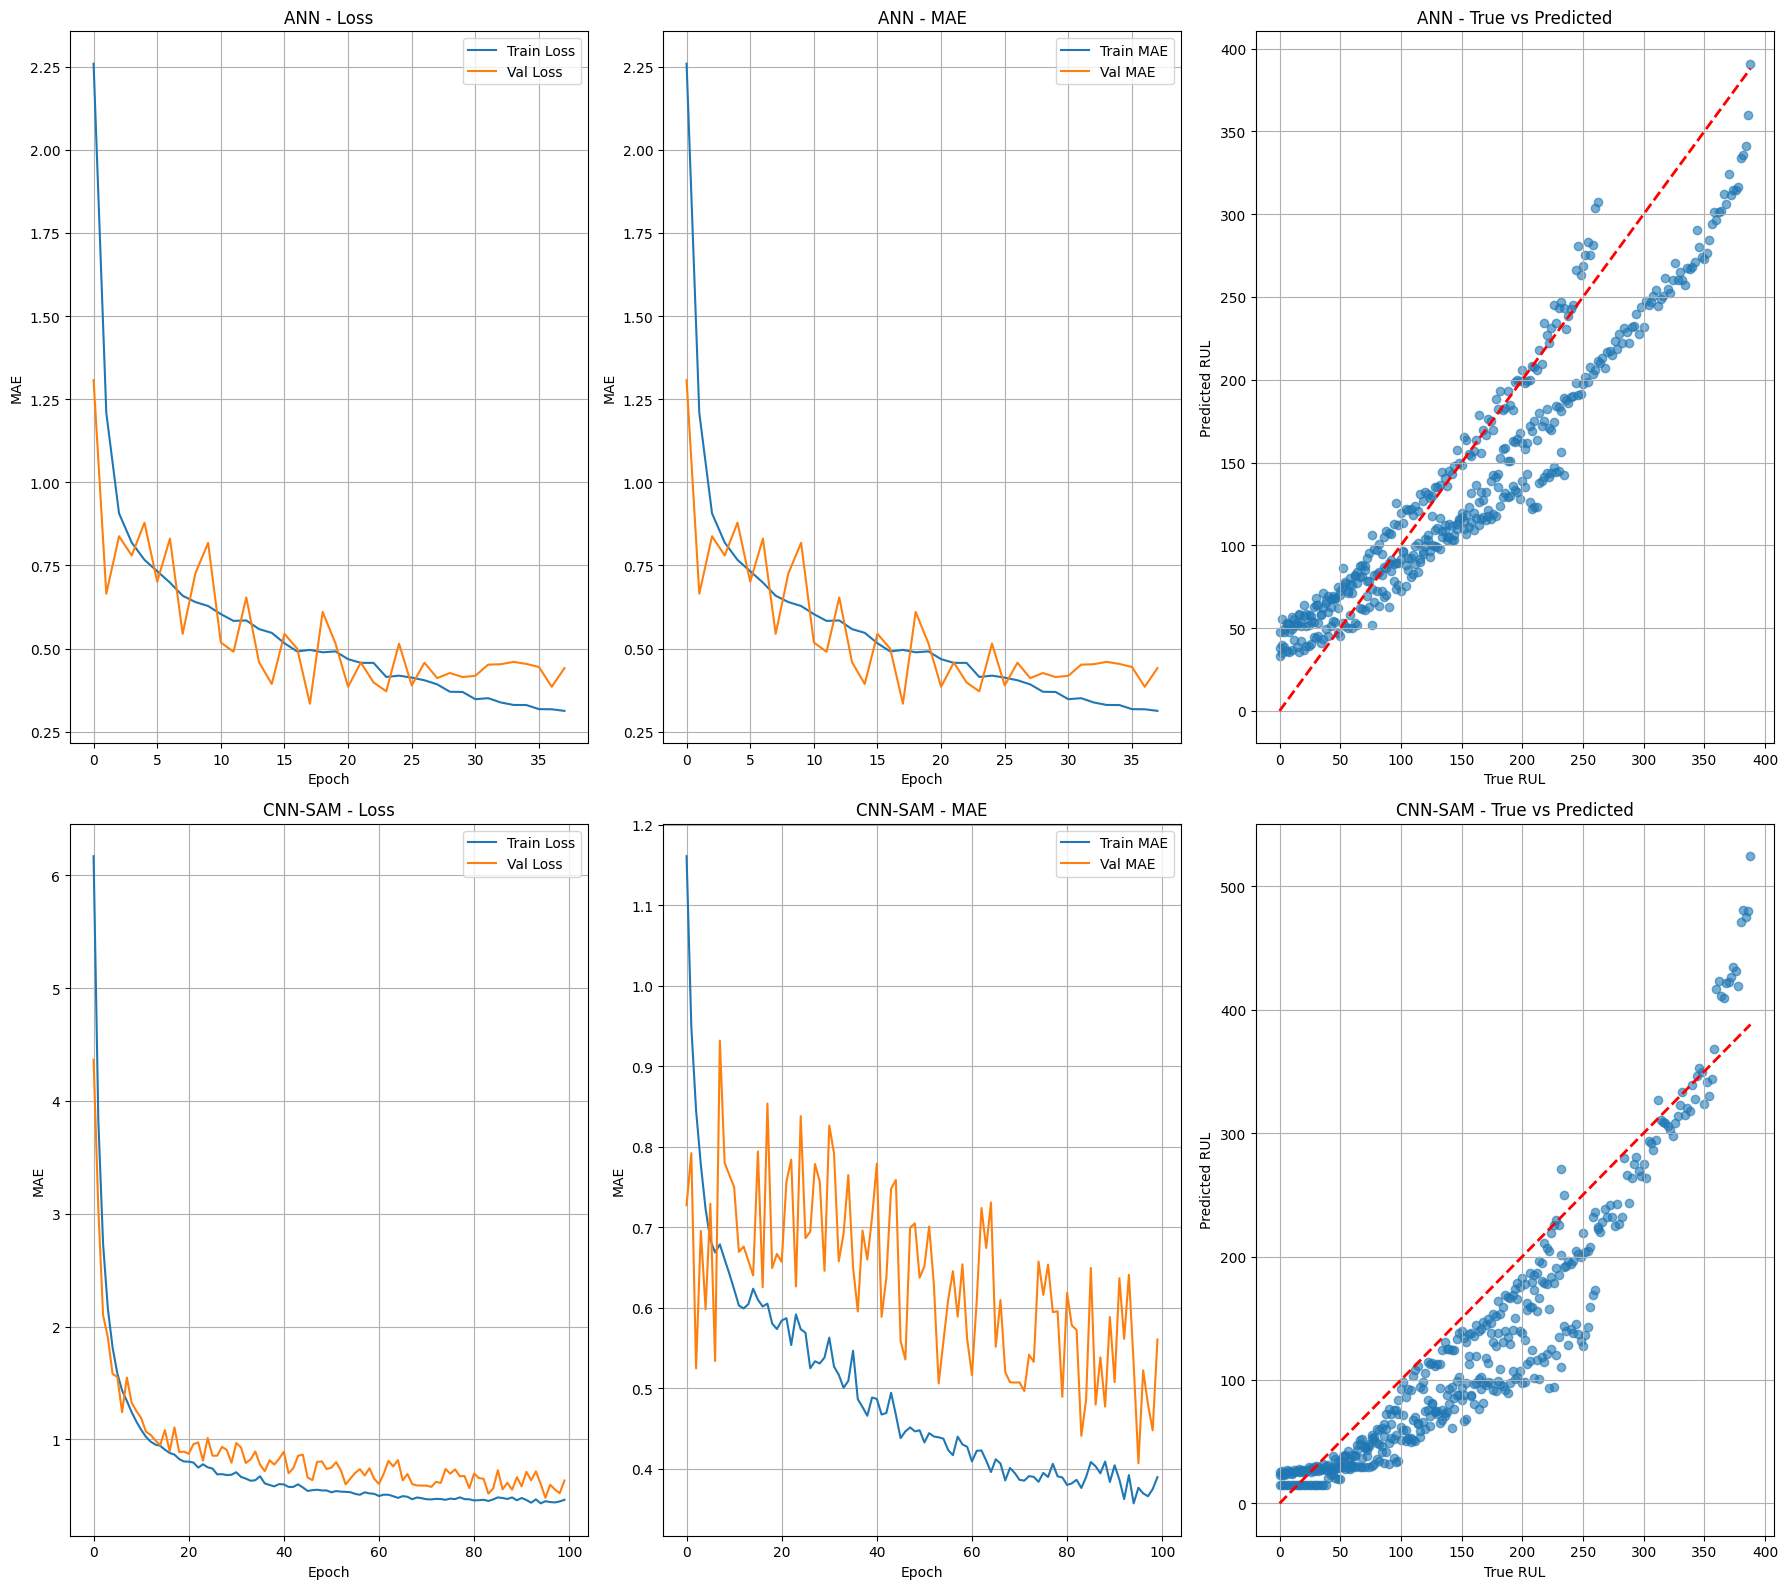

ANN - MSE: 1471.1801, RMSE: 38.3560, MAE: 31.4589, R²: 0.8488
CNN-SAM - MSE: 2298.6990, RMSE: 47.9447, MAE: 38.2210, R²: 0.7637


In [27]:
# Plot Training History and True vs Predicted Results for trained models

fig, axes = plt.subplots(len(model_info), 3, figsize=(18, 8*len(model_info)))
if len(model_info) == 1:
    axes = np.array([axes])

for i, (model_name, model) in enumerate(model_info.items()):
    axes[i, 0].plot(model['history'].history['loss'], label='Train Loss')
    axes[i, 0].plot(model['history'].history['val_loss'], label='Val Loss')
    axes[i, 0].set_title(f'{model_name} - Loss')
    axes[i, 0].set_xlabel('Epoch')
    axes[i, 0].set_ylabel('MAE')
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    axes[i, 1].plot(model['history'].history['mae'], label='Train MAE')
    axes[i, 1].plot(model['history'].history['val_mae'], label='Val MAE')
    axes[i, 1].set_title(f'{model_name} - MAE')
    axes[i, 1].set_xlabel('Epoch')
    axes[i, 1].set_ylabel('MAE')
    axes[i, 1].legend()
    axes[i, 1].grid(True)

    axes[i, 2].scatter(model['results'][0], model['results'][1], alpha=0.6)
    ymin, ymax = model['results'][0].min(), model['results'][0].max()
    axes[i, 2].plot([ymin, ymax], [ymin, ymax], 'r--', lw=2)
    axes[i, 2].set_xlabel('True RUL')
    axes[i, 2].set_ylabel('Predicted RUL')
    axes[i, 2].set_title(f'{model_name} - True vs Predicted')
    axes[i, 2].grid(True)

plt.tight_layout()
plt.show()

for model_name, model in model_info.items():
    print(f"{model_name} - MSE: {model['mse']:.4f}, RMSE: {model['rmse']:.4f}, MAE: {model['mae']:.4f}, R²: {model['r2']:.4f}")

ANN
25C01 - ANN R²: 0.566
35C02 - ANN R²: 0.933
45C02 - ANN R²: 0.852
CNN-SAM
25C01 - CNN-SAM R²: 0.923
35C02 - CNN-SAM R²: 0.204
45C02 - CNN-SAM R²: 0.850


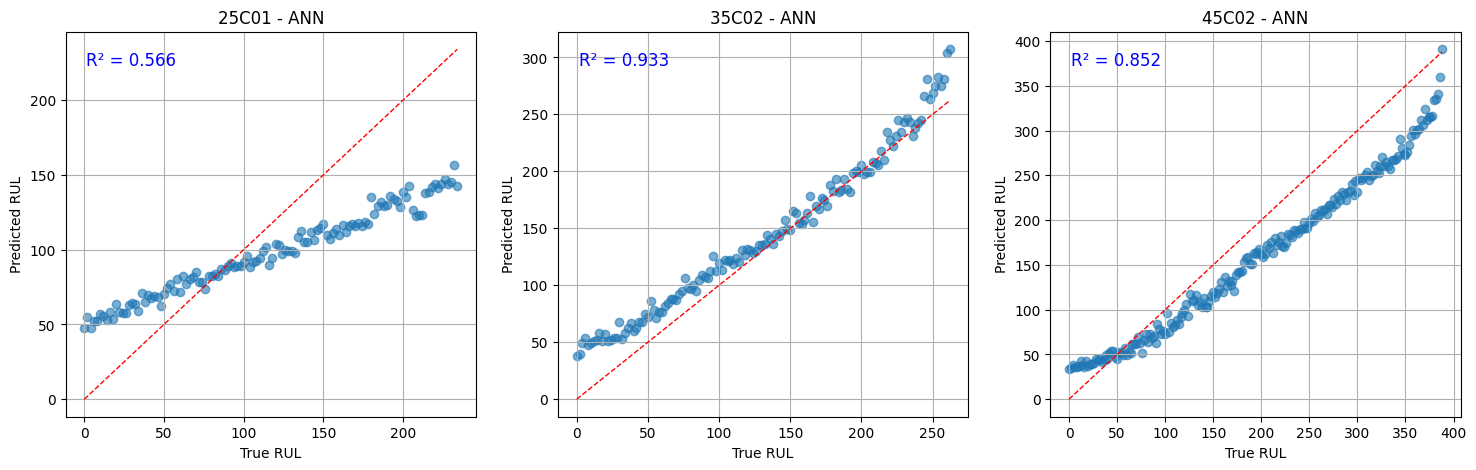

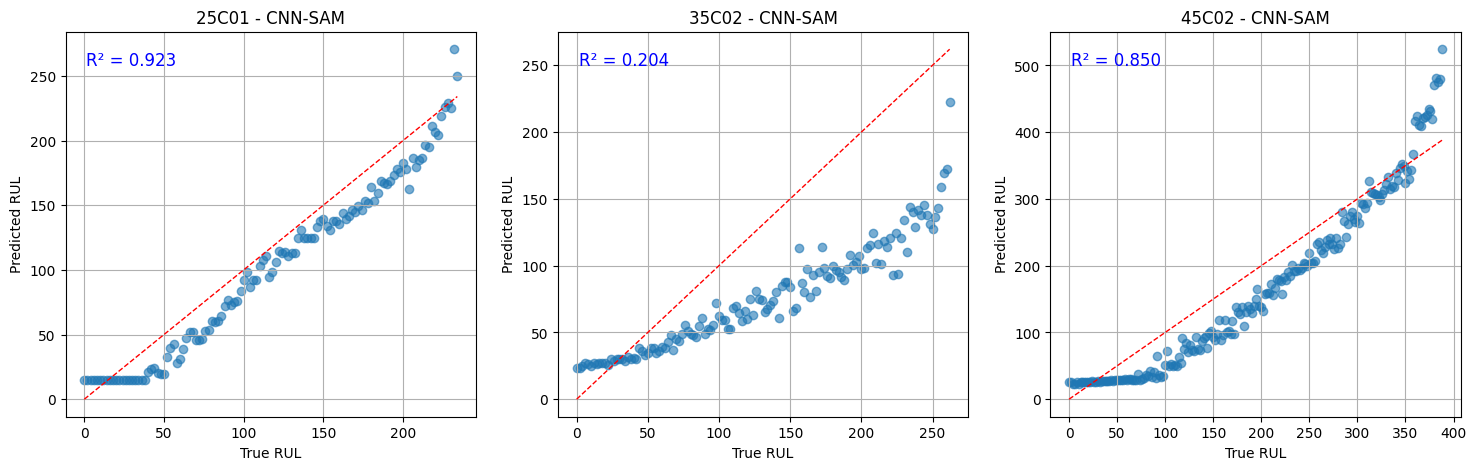

In [28]:
def evaluate_on_individual_batteries(model_name, model):
    """Evaluate each model on individual test batteries and plot results"""
    n = len(testing_batteries)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5), squeeze=False)

    for i, bat in enumerate(testing_batteries):
        # Prepare dataset depending on model type
        if 'ANN' in model_name:
            X, y = prepare_flatten_dataset(battery_data, [bat], features=FEATURES, frequencies_max=FREQUENCIES_MAX)
        else:
            X, y = prepare_3d_dataset(battery_data, [bat], features=FEATURES, frequencies_max=FREQUENCIES_MAX)

        # Scale + predict
        X = model['scaler'].transform(X)
        y_pred = model['model'].predict(X, verbose=0).flatten()
        y_pred = log_inverse(y_pred)

        # Metrics
        r2 = r2_score(y, y_pred)
        print(f"{bat} - {model_name} R²: {r2:.3f}")

        ax = axes[0, i]
        ax.scatter(y, y_pred, alpha=0.6)
        ymin, ymax = y.min(), y.max()
        ax.plot([ymin, ymax], [ymin, ymax], 'r--', lw=1)
        ax.set_title(f'{bat} - {model_name}')
        ax.set_xlabel('True RUL')
        ax.set_ylabel('Predicted RUL')
        ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, fontsize=12, color='blue', va='top')
        ax.grid(True)

for model_name, model in model_info.items():
    print(model_name)
    evaluate_on_individual_batteries(model_name, model)

# Model summary and quantization

In [29]:
for model_name, model in model_info.items():
    print(model_name)
    print(model['model'].summary())
    model['model'].save(f"{model_name}_rul_model.keras")

ANN
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7808      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)             

In [30]:
for model_name, info in model_info.items():
    model = keras.models.load_model(f"{model_name}_rul_model.keras")

    # Prune the model
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.50,
            final_sparsity=0.80,
            begin_step=0,
            end_step=np.ceil(len(X_train_flat) / BATCH_SIZE).astype(np.int32) * EPOCHS
        )
    }
    model_for_pruning = prune_low_magnitude(model, **pruning_params)
    model_for_pruning.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mae',
        metrics=['mae']
    )
    model_for_pruning.fit(
        train_flat_ds if 'ANN' in model_name else train_3d_ds,
        validation_data=test_flat_ds if 'ANN' in model_name else test_3d_ds,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[early_stopping, reduce_lr, tfmot.sparsity.keras.UpdatePruningStep()]
    )
    model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
    model_for_export.save(f"{model_name}_rul_model_pruned.keras")

    # Convert to TFLite with quantization
    converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_quant_model = converter.convert()
    with open(f"{model_name}_rul_model.tflite", "wb") as f:
        f.write(tflite_quant_model)

Epoch 1/100
51/51 [==============================] - 6s 8ms/step - loss: 0.5023 - mae: 0.5023 - val_loss: 0.5772 - val_mae: 0.5772 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 0.5371 - mae: 0.5371 - val_loss: 1.7783 - val_mae: 1.7783 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 0.7891 - mae: 0.7891 - val_loss: 0.4992 - val_mae: 0.4992 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 0.5742 - mae: 0.5742 - val_loss: 0.3804 - val_mae: 0.3804 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.5591 - mae: 0.5591 - val_loss: 0.4373 - val_mae: 0.4373 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 0s 3ms/step - loss: 0.5440 - mae: 0.5440 - val_loss: 0.3577 - val_mae: 0.3577 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 0s 3ms/step - loss: 0.5277 - mae: 0.5277 - val_loss: 0.3760 - val_mae: 0.3760 - lr:

W0000 00:00:1758298781.022901   25976 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1758298781.022971   25976 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1758298781.033357   25976 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Epoch 1/100
51/51 [==============================] - 13s 28ms/step - loss: 0.5172 - mae: 0.4410 - val_loss: 0.7290 - val_mae: 0.6533 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 1s 15ms/step - loss: 0.4925 - mae: 0.4168 - val_loss: 0.7256 - val_mae: 0.6512 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 1s 15ms/step - loss: 0.4798 - mae: 0.4027 - val_loss: 0.6239 - val_mae: 0.5481 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 1s 15ms/step - loss: 0.4740 - mae: 0.3979 - val_loss: 0.4765 - val_mae: 0.4007 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 1s 14ms/step - loss: 0.4795 - mae: 0.4035 - val_loss: 0.6113 - val_mae: 0.5359 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 1s 14ms/step - loss: 0.4760 - mae: 0.4003 - val_loss: 0.7248 - val_mae: 0.6500 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 1s 15ms/step - loss: 0.4842 - mae: 0.4093 - val_loss: 0.5351 - val_mae: 0.45

W0000 00:00:1758298828.850811   25976 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1758298828.850847   25976 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [31]:
for model_name in model_info.keys():
    original_model_path = f"{model_name}_rul_model.keras"
    original_size = os.path.getsize(original_model_path) / 1024
    quantized_model_path = f"{model_name}_rul_model.tflite"
    quantized_size = os.path.getsize(quantized_model_path) / 1024
    print(f"{model_name} - Original size: {original_size:.2f} KB")
    print(f"{model_name} - Quantized size: {quantized_size:.2f} KB")

    interpreter = tf.lite.Interpreter(model_path=quantized_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    print(f"{model_name} - Input details: {input_details}")
    print(f"{model_name} - Output details: {output_details}")

ANN - Original size: 259.86 KB
ANN - Quantized size: 25.51 KB
ANN - Input details: [{'name': 'serving_default_dense_input:0', 'index': 0, 'shape': array([ 1, 60], dtype=int32), 'shape_signature': array([-1, 60], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
ANN - Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 14, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
CNN-SAM - Original size: 1676.40 KB
CNN-SAM - Quantized size: 161.71 KB
CNN-SAM - Input details: [{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 60,  1], d

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Per-battery predictions and metrics:


,battery,model,variant,N,MSE,RMSE,MAE,R2
0,25C01,ANN,Keras,118,2012.662476,44.862705,37.775833,0.566330
1,25C01,ANN,TFLite INT8,118,952.741577,30.866512,24.819576,0.794712
6,25C01,CNN-SAM,Keras,118,355.942230,18.866432,17.118382,0.923305
7,25C01,CNN-SAM,TFLite INT8,118,159.513596,12.629869,10.050202,0.965629
2,35C02,ANN,Keras,132,391.060791,19.775257,15.703856,0.932665
3,35C02,ANN,TFLite INT8,132,435.471527,20.867954,18.176420,0.925018
8,35C02,CNN-SAM,Keras,132,4622.604980,67.989738,57.566570,0.204051
9,35C02,CNN-SAM,TFLite INT8,132,2834.436035,53.239422,44.847710,0.511949
4,45C02,ANN,Keras,195,1874.671509,43.297478,38.301331,0.852093
5,45C02,ANN,TFLite INT8,195,2096.139404,45.783615,39.872726,0.834620



Average by battery and variant:


R2        MAE       RMSE
battery variant                                    
25C01   Keras        0.744817  27.447107  31.864569
        TFLite INT8  0.880171  17.434889  21.748192
35C02   Keras        0.568358  36.635212  43.882500
        TFLite INT8  0.718484  31.512066  37.053688
45C02   Keras        0.851046  38.098351  43.450172
        TFLite INT8  0.841358  37.032555  44.831039

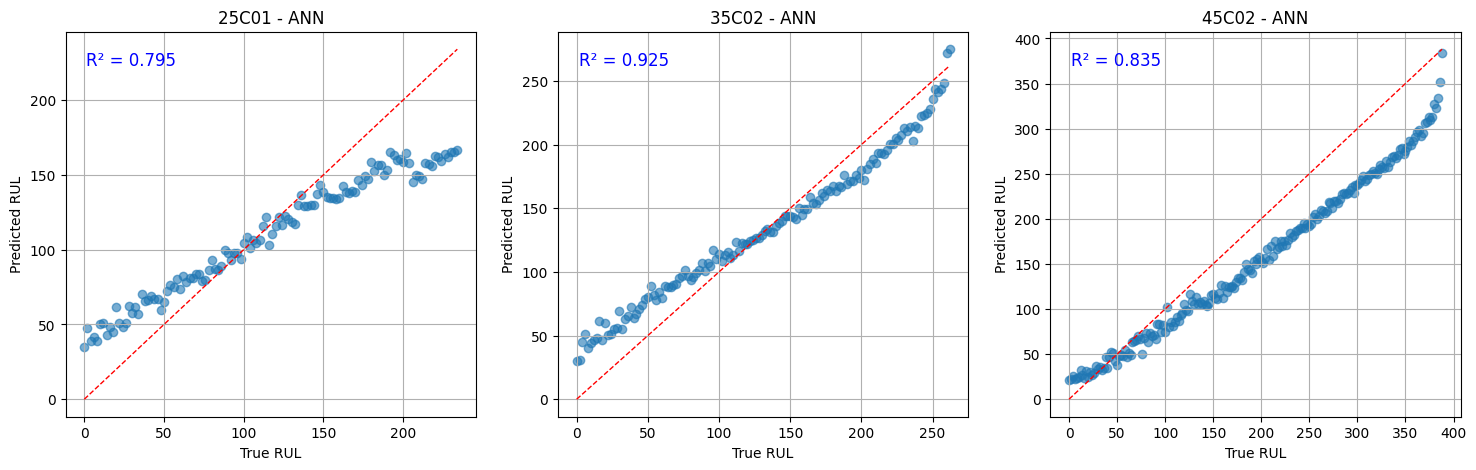

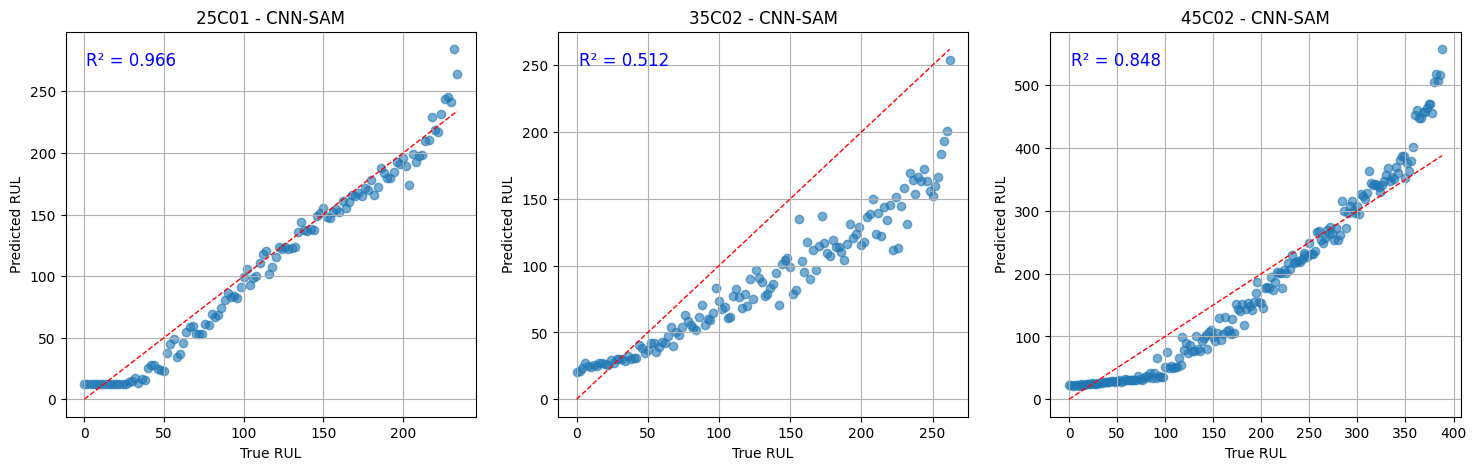

In [42]:
def _tflite_predict(model_name: str, X: np.ndarray, batch: int = 512) -> np.ndarray:
    path = f"{model_name}_rul_model.tflite"
    interpreter = tf.lite.Interpreter(model_path=path)
    preds = []
    i = 0
    while i < len(X):
        xb = X[i:i+batch].astype(np.float32)
        input_index = interpreter.get_input_details()[0]['index']
        interpreter.resize_tensor_input(input_index, xb.shape)
        interpreter.allocate_tensors()
        interpreter.set_tensor(input_index, xb)
        interpreter.invoke()
        yb = interpreter.get_tensor(interpreter.get_output_details()[0]['index']).reshape(-1)
        preds.append(yb)
        i += len(xb)
    return np.concatenate(preds, axis=0)

def compare_per_battery_predictions(save_csv=False):
    rows, per_battery = [], {}
    for model_name, info in model_info.items():
        n = len(testing_batteries)
        fig, axes = plt.subplots(1, n, figsize=(6*n, 5), squeeze=False)

        for i, bat in enumerate(testing_batteries):
            if 'ANN' in model_name:
                X, y = prepare_flatten_dataset(battery_data, [bat], features=FEATURES, frequencies_max=FREQUENCIES_MAX)
            else:
                X, y = prepare_3d_dataset(battery_data, [bat], features=FEATURES, frequencies_max=FREQUENCIES_MAX)
            Xs = info['scaler'].transform(X)
            y_keras = log_inverse(info['model'].predict(Xs, verbose=0).reshape(-1))
            y_tflite = log_inverse(_tflite_predict(model_name, Xs))
            dfp = pd.DataFrame({
                "battery": bat,
                "model": model_name,
                "y_true": y,
                "y_pred_keras": y_keras,
                "y_pred_tflite": y_tflite
            })
            per_battery[(model_name, bat)] = dfp
            if save_csv:
                dfp.to_csv(f"{model_name}_{bat}_predictions.csv", index=False)

            def metr(yv, yp):
                mse = mean_squared_error(yv, yp)
                return mse, np.sqrt(mse), mean_absolute_error(yv, yp), r2_score(yv, yp)

            for variant, yp in (("Keras", y_keras), ("TFLite INT8", y_tflite)):
                mse, rmse, mae, r2 = metr(y, yp)
                rows.append({"battery": bat, "model": model_name, "variant": variant, "N": len(y),
                             "MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2})

            ax = axes[0, i]
            ax.scatter(y, y_tflite, alpha=0.6)
            ymin, ymax = y.min(), y.max()
            ax.plot([ymin, ymax], [ymin, ymax], 'r--', lw=1)
            ax.set_title(f'{bat} - {model_name}')
            ax.set_xlabel('True RUL')
            ax.set_ylabel('Predicted RUL')
            ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, fontsize=12, color='blue', va='top')
            ax.grid(True)

    summary = pd.DataFrame(rows).sort_values(["battery", "model", "variant"])
    print("Per-battery predictions and metrics:")
    display(summary)
    print("\nAverage by battery and variant:")
    display(summary.groupby(["battery", "variant"])[["R2", "MAE", "RMSE"]].mean())
    return summary, per_battery

summary_df, preds = compare_per_battery_predictions(save_csv=True)

In [35]:
pivot_df = summary_df.pivot_table(index=['battery'], columns=['model', 'variant'], values=['R2'])
print("Pivoted summary:")
display(pivot_df)

Pivoted summary:


R2                                  
model         ANN               CNN-SAM            
variant     Keras TFLite INT8     Keras TFLite INT8
battery                                            
25C01    0.566330    0.794712  0.923305    0.965629
35C02    0.932665    0.925018  0.204051    0.511949
45C02    0.852093    0.834620  0.849999    0.848097